<img src="./document/Picture1.png" width="500" height="300">



### ROI extract
1. We need to get the Region of Interest (ROI) from the DSLR image first. and actuaclly, what we really interested is the material part. so, we can extract the ROI from the image. 


[Model: Segemnt Everything](https://segment-anything.com/demo)

### Get the infomation from the ROI
0. **Area** 
1. **Parimeter**
2. **Aspect Ratio:** The aspect ratio compares the width to the height of the shape. A perfect circle has an aspect ratio of 1, while elongated or irregular shapes have values different from 1.

3. **Convexity:** Convexity measures how convex or concave a shape is. Convex shapes have a higher value, while concave shapes have a lower value. It's calculated by dividing the area of the shape by the area of its convex hull.

4. **Circularity:** Circularity measures how close the shape is to a perfect circle. It is calculated as the ratio of the area of the shape to the area of a circle with the same perimeter (circumference). A perfect circle has a circularity of 1, while irregular shapes have values less than 1.

5. **Fractal Dimension:** Fractal dimension measures how complex and irregular a shape is. You can use algorithms like the box-counting method to estimate the fractal dimension. ->not work

These features are popular used in research. 
Nowaday, it is popular to extract infomation from every pixel and location, e.g. Convolutional Neural Network. However, the amount of images is limited so it's not a good idea to use CNN to extract the features. Therefore, we use these five defined features to represent an image.

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np

In [2]:
def calculate_aspect_ratio(contour):
    x, y, width, height = cv2.boundingRect(contour)
    object_width = width
    object_height = height
    aspect_ratio = width / height
    return aspect_ratio

def calculate_convexity(contour):
    hull = cv2.convexHull(contour)
    convexity = cv2.contourArea(contour) / cv2.contourArea(hull)
    return convexity

def calculate_circularity(area,perimeter):
    circularity = (4 * np.pi * area) / (perimeter**2)
    return circularity

def fractal_dimention(contours,n=20):
    # Initialize a list to store the number of boxes and corresponding box sizes
    num_boxes = []
    box_sizes = []

    # Iterate through different box sizes
    for box_size in range(1, 20):  # You can adjust the range based on your image size
        count = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w <= box_size and h <= box_size:
                count += 1
        num_boxes.append(count)
        box_sizes.append(box_size)

    # Filter out invalid data points where either num_boxes or box_sizes is zero
    valid_data_indices = [i for i, (num, size) in enumerate(zip(num_boxes, box_sizes)) if num > 0 and size > 0]
    filtered_num_boxes = [num_boxes[i] for i in valid_data_indices]
    filtered_box_sizes = [box_sizes[i] for i in valid_data_indices]

    # Check if there are valid data points for calculation
    if len(filtered_num_boxes) > 0 and len(filtered_box_sizes) > 0:
        # Fit a linear regression model to the data (log-log plot)
        coefficients = np.polyfit(np.log(filtered_box_sizes), np.log(filtered_num_boxes), 1)

        # The first coefficient is the fractal dimension
        fractal_dimension = -coefficients[0]

        print("Fractal Dimension:", fractal_dimension)

        # Plot the data points and the fitted line (log-log plot)
        plt.figure()
        plt.loglog(filtered_box_sizes, filtered_num_boxes, 'bo-')
        plt.xlabel('Box Size (log scale)')
        plt.ylabel('Number of Boxes (log scale)')
        plt.title('Box Counting Method for Fractal Dimension')
        plt.grid(True)
        plt.show()
    else:
        print("No valid data points for fractal dimension calculation.")


In [3]:
def single_image_process(path):
    
    image = cv2.imread(path)

#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #binary
    _, thresholded = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # Find contours in the binary mask
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Iterate through the contours and calculate their perimeters
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, closed=True)
#     print("Perimeter of crack area:", perimeter)
    #########Area
    area = cv2.countNonZero(thresholded)
#     print("crack area:", area)

    calculate_circularity_value = calculate_circularity(area, perimeter)
#     print('circularity',calculate_circularity_value)

    for contour in contours:
        aspect_ratio_value = calculate_aspect_ratio(contour)
#         print('Aspect Ratio:', aspect_ratio_value)
        convexity_value = calculate_convexity(contour)
#         print('Convexity:', convexity_value)
        
    return perimeter, area, calculate_circularity_value, aspect_ratio_value,convexity_value
    

Perimeter of crack area: 6757.54031932354
crack area: 2544921
circularity 0.7003366883088065
Aspect Ratio: 1.1252420916720465
Convexity: 0.9674834812818948
No valid data points for fractal dimension calculation.


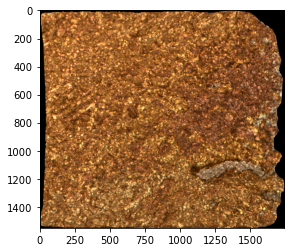

In [4]:
image = cv2.imread('./DSLR-segment/A1-down-crack.png')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#binary
_, thresholded = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
# Find contours in the binary mask
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Iterate through the contours and calculate their perimeters
perimeter = 0
for contour in contours:
    perimeter += cv2.arcLength(contour, closed=True)
print("Perimeter of crack area:", perimeter)
#########Area
area = cv2.countNonZero(thresholded)
print("crack area:", area)

calculate_circularity_value = calculate_circularity(area, perimeter)
print('circularity',calculate_circularity_value)

for contour in contours:
    aspect_ratio_value = calculate_aspect_ratio(contour)
    print('Aspect Ratio:', aspect_ratio_value)
    convexity_value = calculate_convexity(contour)
    print('Convexity:', convexity_value)
fractal_dimention(contours,n=2)

### Do process to all images

calculate all the features and save them into MSexcel file

In [5]:
# Specify the directory path
folder_path = './DSLR-segment'
file_names = glob.glob(os.path.join(folder_path, '*.png'))
print(file_names)
# Get a list of all files in the folder
# file_names = os.listdir(folder_path)

# Print the list of file names
all_name=[]
all_perimeter = []
all_area = []
all_calculate_circularity_value=[]
all_aspect_ratio_value=[]
all_convexity_value=[]

for file_name in file_names:
#     image_path = folder_path +'/'+ file_name
    print(file_name)
    all_name.append(file_name[15:-4])
    perimeter, area, calculate_circularity_value, aspect_ratio_value,convexity_value = single_image_process(file_name)
    all_perimeter.append(perimeter)
    all_area.append(area)
    all_calculate_circularity_value.append(calculate_circularity_value)
    all_aspect_ratio_value.append(aspect_ratio_value)
    all_convexity_value.append(convexity_value)
    
    
df = pd.DataFrame({
    'name': all_name,
    'parimeter': all_perimeter,
    'area': all_area,
    'circularity': all_calculate_circularity_value,
    'aspect_ratio': all_aspect_ratio_value,
    'convexity':all_convexity_value
    
})    

excel_file = 'output.xlsx'

df.to_excel(excel_file, index=False) 


['./DSLR-segment/A6-up-non-crack.png', './DSLR-segment/A29-down-non-crack.png', './DSLR-segment/A47-down-non-crack.png', './DSLR-segment/A1-down-crack.png', './DSLR-segment/A24-down-non-crack.png', './DSLR-segment/A42-up-crack.png', './DSLR-segment/A9-down-crack.png', './DSLR-segment/A45-up-crack.png', './DSLR-segment/A10-up-crack.png', './DSLR-segment/A8-down-non-crack.png', './DSLR-segment/A40-up-non-crack.png', './DSLR-segment/A14-down-crack.png', './DSLR-segment/A39-down-non-crack.png', './DSLR-segment/A5-down-non-crack.png', './DSLR-segment/A21-up-crack.png', './DSLR-segment/A6-down-crack.png', './DSLR-segment/A3-up-crack.png', './DSLR-segment/A14-down-non-crack.png', './DSLR-segment/A4-up-crack.png', './DSLR-segment/A33-up-crack.png', './DSLR-segment/A13-down-crack.png', './DSLR-segment/A10-up-non-crack.png', './DSLR-segment/A44-up-crack.png', './DSLR-segment/A16-up-crack.png', './DSLR-segment/A43-up-crack.png', './DSLR-segment/A14-up-non-crack.png', './DSLR-segment/A9-up-non-cra

./DSLR-segment/A2-down-non-crack.png
./DSLR-segment/A38-down-crack.png
./DSLR-segment/A27-up-non-crack.png
./DSLR-segment/A38-up-non-crack.png
./DSLR-segment/A40-down-non-crack.png
./DSLR-segment/A30-down-crack.png
./DSLR-segment/A23-down-non-crack.png
./DSLR-segment/A4-up-non-crack.png
./DSLR-segment/A41-down-crack.png
./DSLR-segment/A24-down-crack.png
./DSLR-segment/A43-down-non-crack.png
./DSLR-segment/A20-down-non-crack.png
./DSLR-segment/A40-down-crack.png
./DSLR-segment/A28-up-crack.png
./DSLR-segment/A1-down-non-crack.png
./DSLR-segment/A30-down-non-crack.png
./DSLR-segment/A46-up-non-crack.png
./DSLR-segment/A48-down-crack.png
./DSLR-segment/A23-up-non-crack.png
./DSLR-segment/A39-down-crack.png
./DSLR-segment/A36-down-crack.png
./DSLR-segment/A23-down-crack.png
./DSLR-segment/A37-up-non-crack.png
./DSLR-segment/A47-down-crack.png
./DSLR-segment/A16-up-non-crack.png
./DSLR-segment/A28-up-non-crack.png
./DSLR-segment/A10-down-non-crack.png
./DSLR-segment/A45-down-crack.png
./DSL